In [1]:
library(tidyverse)
library(cowplot)
library(ggExtra)
library(ggbeeswarm)
library(ggrepel)

`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# Unpermuted network feature values

In [55]:
unperm_df <- read_tsv('../../data/ppi_feature_values.tsv')

unperm_df %>% head(2)

Parsed with column specification:
cols(
  id_a = col_double(),
  id_b = col_double(),
  edge = col_logical(),
  edge_prior = col_double(),
  adamic = col_double(),
  jaccard = col_double(),
  preferential_attachment = col_double(),
  resource_allocation = col_double(),
  rwr = col_double()
)


id_a,id_b,edge,edge_prior,adamic,jaccard,preferential_attachment,resource_allocation,rwr
<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,FALSE,0.6880165,14.8272770,1.000000000,5625,0.546691570,2.511017e-01
0,1,FALSE,0.0530303,0.0000000,0.000000000,225,0.000000000,1.296615e-05
0,2,FALSE,0.8030303,0.4268656,0.012269939,6750,0.018678658,8.327836e-05
0,3,FALSE,2.4034091,0.7047739,0.013840830,16350,0.014244549,8.397111e-05
0,4,FALSE,3.8484848,0.3482255,0.004705882,26400,0.006773838,9.265730e-05
0,5,FALSE,0.6650718,0.1783866,0.007246377,4800,0.003690037,4.861231e-05


In [64]:
unperm_features_df <- unperm_df %>%
    filter(id_a != id_b & edge == 0) %>%
    mutate(degree_product = preferential_attachment) %>%
    gather('feature', 'value', adamic, jaccard, preferential_attachment, resource_allocation, rwr) %>%
    mutate(
        feature = feature %>% recode_factor(
            adamic = 'Adamic/Adar index',
            jaccard = 'Jaccard index',
            preferential_attachment = 'Preferential attachment\nindex',
            resource_allocation = 'Resource allocation\nindex',
            rwr = 'Random walk\nwith restart',
        )
    )

In [65]:
features_df <- unperm_features_df %>%
    group_by(feature) %>%
    sample_n(10000)

correlation_df <- unperm_features_df %>%
    group_by(feature) %>%
    summarize(correlation = cor(degree_product, value, method = 'pearson')) %>%
    ungroup() %>%
    mutate(label = sprintf(fmt = 'r = %.1f', correlation))

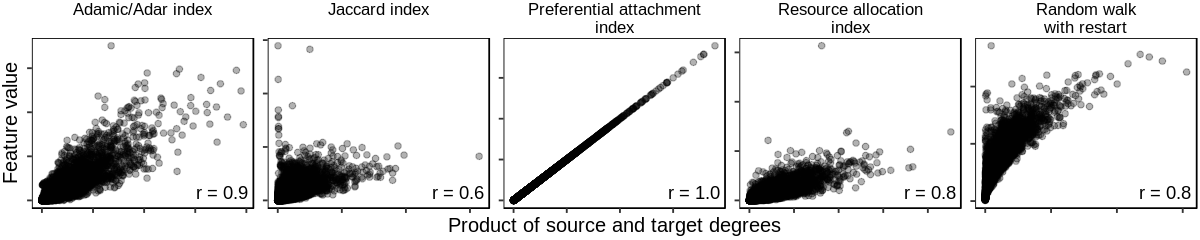

In [185]:
options(repr.plot.width=10, repr.plot.height=2)

unperm_features_plot <- features_df %>%
    ggplot(aes(x = degree_product, y = value)) +
    geom_point(alpha = 0.3) +
    geom_text(data = correlation_df, aes(label = label), x = Inf, y = -Inf, vjust = -0.7, hjust = 1.1) +
    facet_wrap(vars(feature), scales = 'free', nrow = 1) +
    theme_zietzm() +
    theme(axis.text = element_blank(), axis.title = element_text(size = 12, color = 'black')) +
    xlab('Product of source and target degrees') +
    ylab('Feature value')

unperm_features_plot

# Permuted AUROC distributions

In [2]:
unperm_auroc_df <- read_tsv('../../data/unpermuted_auroc_value.tsv') %>% 
    spread(feature, auroc) %>%
    mutate(prior = edge_prior) %>%
    gather('feature', 'value', -prior)
#     gather('feature', 'value', -edge_prior)

permuted_auroc_df <- read_tsv('../../data/permuted_auroc_values.tsv')

Parsed with column specification:
cols(
  feature = col_character(),
  auroc = col_double()
)
Parsed with column specification:
cols(
  adamic = col_double(),
  jaccard = col_double(),
  preferential_attachment = col_double(),
  resource_allocation = col_double(),
  rwr = col_double()
)


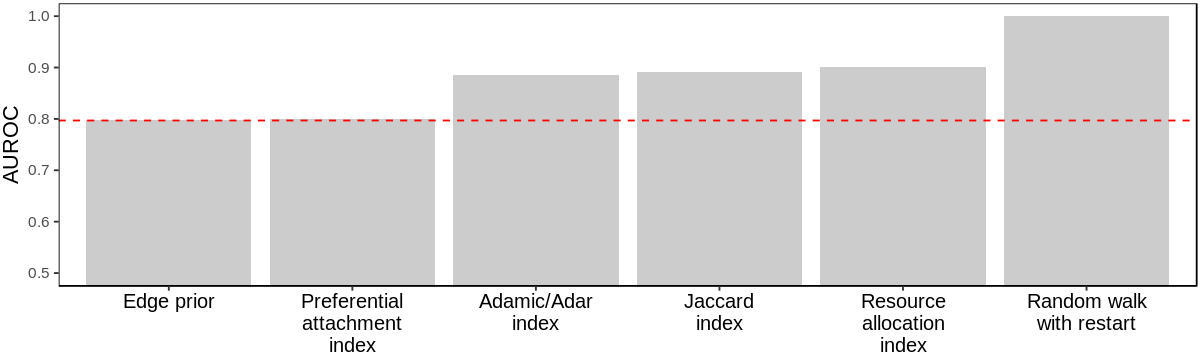

In [197]:
options(repr.plot.width=10, repr.plot.height=3)

feature_auroc_plot <- unperm_auroc_df %>%
mutate(
    feature = feature %>% recode_factor(
        edge_prior = 'Edge prior',
        preferential_attachment = 'Preferential\nattachment\nindex',
        adamic = 'Adamic/Adar\nindex',
        jaccard = 'Jaccard\nindex',
        resource_allocation = 'Resource\nallocation\nindex',
        rwr = 'Random walk\nwith restart')
) %>%
ggplot(aes(x = feature, y = value)) +
geom_col(fill = 'grey80') +
geom_hline(aes(yintercept = prior), color = 'red', linetype = 'dashed') +
coord_cartesian(ylim = c(0.5, 1)) +
ylab('AUROC') +
theme_zietzm() +
theme(axis.title.x = element_blank(), axis.text.x = element_text(size = 12, color = 'black'),
      axis.title.y = element_text(size = 13, color = 'black'))

feature_auroc_plot

Warning message:
“Column `feature` joining factors with different levels, coercing to character vector”

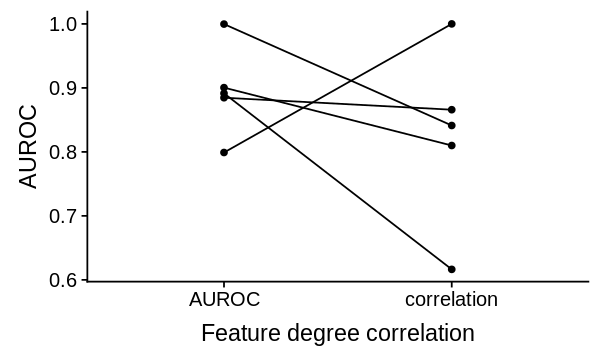

In [234]:
correlation_df %>%
left_join(unperm_auroc_df %>%
              mutate(feature = feature %>% recode_factor(
                  adamic = 'Adamic/Adar index',
                  jaccard = 'Jaccard index',
                  preferential_attachment = 'Preferential attachment\nindex',
                  resource_allocation = 'Resource allocation\nindex',
                  rwr = 'Random walk\nwith restart',)
), by = 'feature') %>%
rename('AUROC' = value) %>%
gather('metric', 'value', correlation, AUROC) %>%
ggplot(aes(x = metric, y = value, group = feature)) +
geom_point() +
geom_line() +
ylab('AUROC') +
xlab('Feature degree correlation')

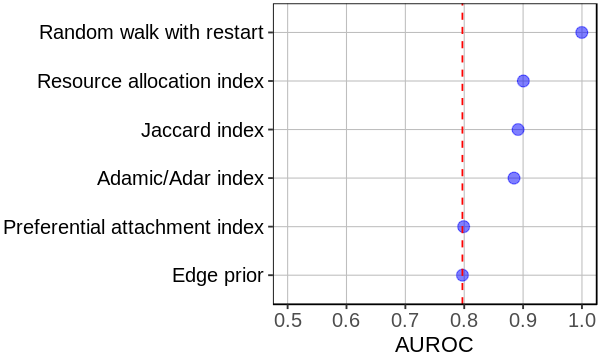

In [235]:
options(repr.plot.width=5, repr.plot.height=3)

auroc_dotplot <- unperm_auroc_df %>%
mutate(
    feature = feature %>% recode_factor(
        edge_prior = 'Edge prior',
        preferential_attachment = 'Preferential attachment index',
        adamic = 'Adamic/Adar index',
        jaccard = 'Jaccard index',
        resource_allocation = 'Resource allocation index',
        rwr = 'Random walk with restart')
) %>%
ggplot(aes(y = feature, x = value)) +
# geom_col(fill = 'grey80') +
geom_point(size = 3, color = 'blue', alpha = 0.5) +
geom_vline(aes(xintercept = prior), color = 'red', linetype = 'dashed') +
coord_cartesian(xlim = c(0.5, 1)) +
xlab('AUROC') +
theme_zietzm() +
theme(axis.title.y = element_blank(), axis.text.y = element_text(size = 12, color = 'black'),
      axis.title.x = element_text(size = 13, color = 'black'), 
      panel.grid.major = element_line(size = 0.3, color = 'grey',),
      axis.text.x = element_text(size = 12))

auroc_dotplot

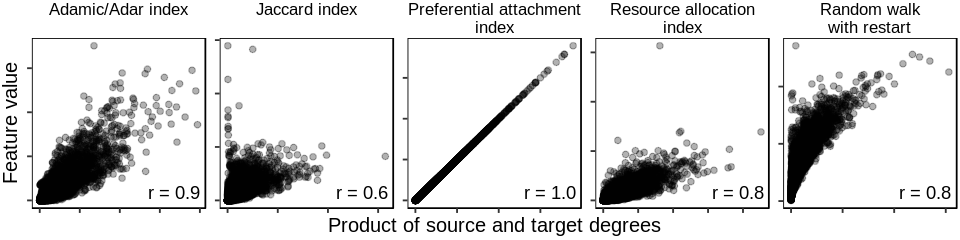

In [243]:
options(repr.plot.width=8, repr.plot.height=2)

ggsave(filename = '../../img/feature-degree.png', unperm_features_plot, width = 8, height = 2, dpi = 300)

unperm_features_plot

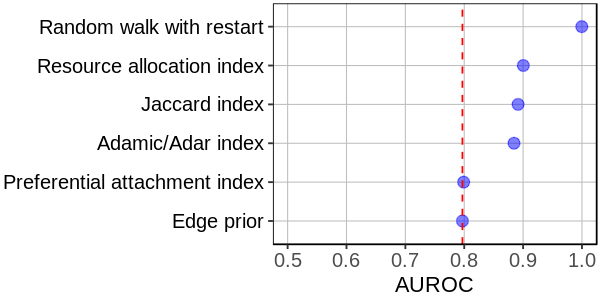

In [244]:
options(repr.plot.width=5, repr.plot.height=2.5)

ggsave(filename = '../../img/feature-auroc.png', auroc_dotplot, width = 5, height = 2.5, dpi = 300)

auroc_dotplot

In [75]:
dotplot_data <- bind_rows(
    unperm_auroc_df %>% mutate(permuted = F),
    permuted_auroc_df %>%
        gather('feature', 'value') %>%
        mutate(permuted = T)
) %>%
mutate(prior = first(prior)) %>%
mutate(
    feature = feature %>% recode_factor(
        edge_prior = 'Edge prior',
        preferential_attachment = 'Preferential attachment index',
        adamic = 'Adamic/Adar index',
        jaccard = 'Jaccard index',
        resource_allocation = 'Resource allocation index',
        rwr = 'Random walk with restart'),
    permuted = factor(permuted, levels = c(T, F))
) %>%
filter(feature != 'Edge prior')

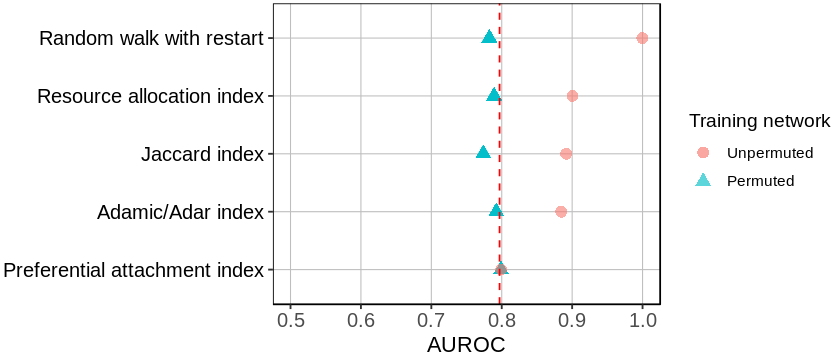

In [80]:
options(repr.plot.width=7, repr.plot.height=3)

auroc_dotplot <- dotplot_data %>%
ggplot(aes(y = feature, x = value, color = permuted, shape = permuted)) +
# geom_col(fill = 'grey80') +
# geom_point(size = 3, alpha = 0.5) +
geom_point(data = dotplot_data %>% filter(permuted == T), size = 3, alpha = 0.1) +
geom_point(data = dotplot_data %>% filter(permuted == F), size = 3, alpha = 0.6) +
geom_vline(aes(xintercept = prior), color = 'red', linetype = 'dashed') +
coord_cartesian(xlim = c(0.5, 1)) +
xlab('AUROC') +
theme_zietzm() +
theme(axis.title.y = element_blank(), axis.text.y = element_text(size = 12, color = 'black'),
      axis.title.x = element_text(size = 13, color = 'black'), 
      panel.grid.major = element_line(size = 0.3, color = 'grey',),
      axis.text.x = element_text(size = 12)) +
scale_color_discrete(name = 'Training network', labels = c("Unpermuted", "Permuted")) +
scale_shape(name = 'Training network', labels = c("Unpermuted", "Permuted"))

auroc_dotplot

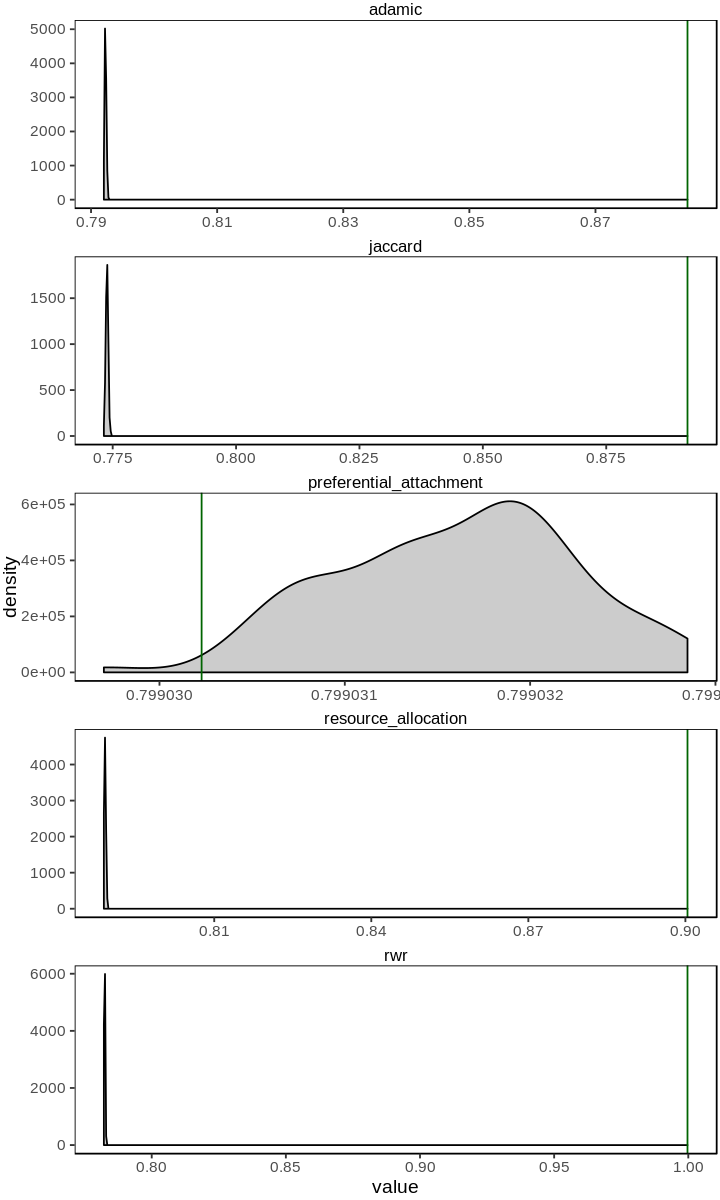

In [46]:
options(repr.plot.width=6, repr.plot.height=10)

permuted_auroc_df %>%
gather('feature', 'value') %>%
ggplot(aes(x = value)) +
facet_wrap(vars(feature), scales = 'free', ncol = 1) +
# geom_histogram(bins = 200) +
geom_density(fill = 'grey80') +
# geom_density() +
geom_vline(data = unperm_auroc_df %>% filter(feature != 'edge_prior'), aes(xintercept = value), 
           color = 'darkgreen') +
theme_zietzm()